In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ABBREV.csv to ABBREV.csv



Class distribution:
 deficiency
Carb Deficiency       572
Balanced              285
Fat Deficiency        125
Protein Deficiency     90
Name: count, dtype: int64


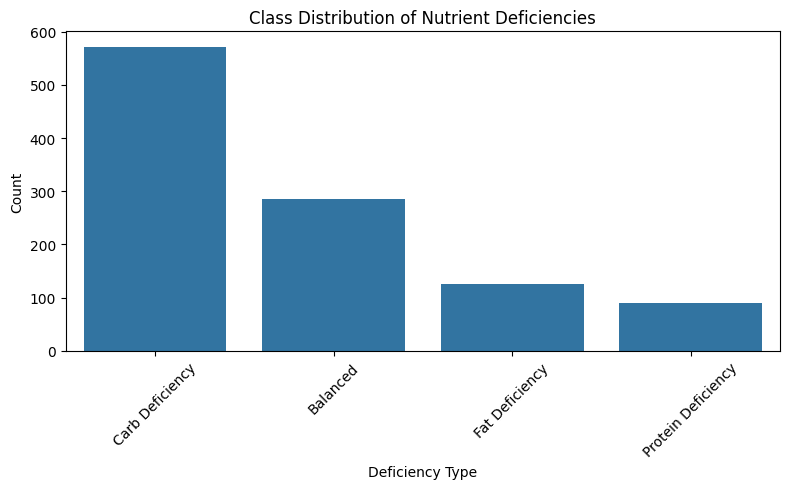


Logistic Regression Accuracy: 0.92
Logistic Regression Classification Report:
                    precision    recall  f1-score   support

          Balanced       0.87      0.92      0.89        50
   Carb Deficiency       0.97      0.99      0.98       118
    Fat Deficiency       0.85      0.74      0.79        31
Protein Deficiency       0.73      0.69      0.71        16

          accuracy                           0.92       215
         macro avg       0.86      0.84      0.84       215
      weighted avg       0.91      0.92      0.91       215


Support Vector Machine Accuracy: 0.88
Support Vector Machine Classification Report:
                    precision    recall  f1-score   support

          Balanced       0.80      0.88      0.84        50
   Carb Deficiency       0.97      0.98      0.98       118
    Fat Deficiency       0.73      0.61      0.67        31
Protein Deficiency       0.73      0.69      0.71        16

          accuracy                           0.88  

<ipython-input-2-694554934>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=model_scores, palette="viridis")


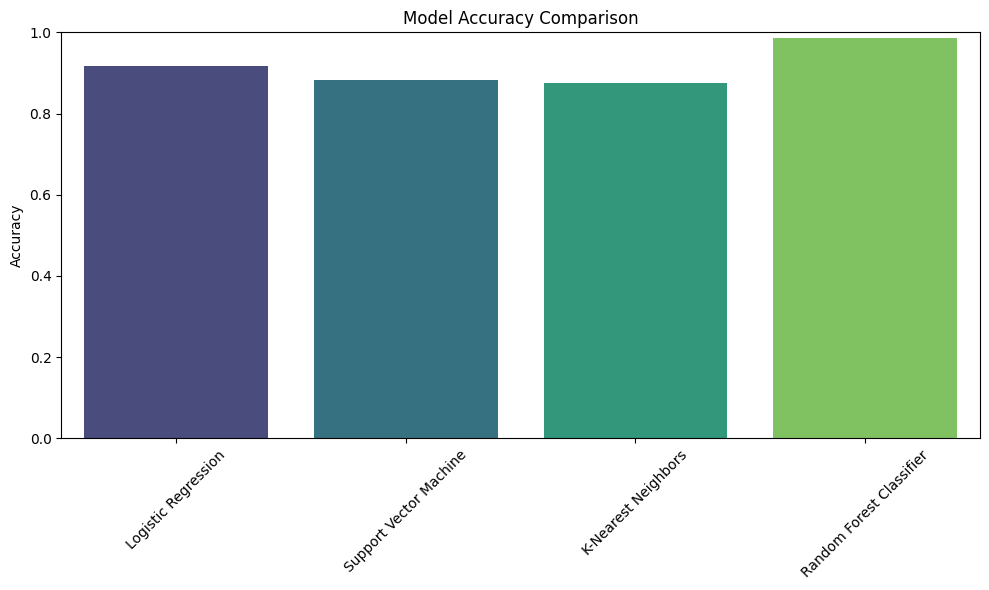

<ipython-input-2-694554934>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10], palette="magma")


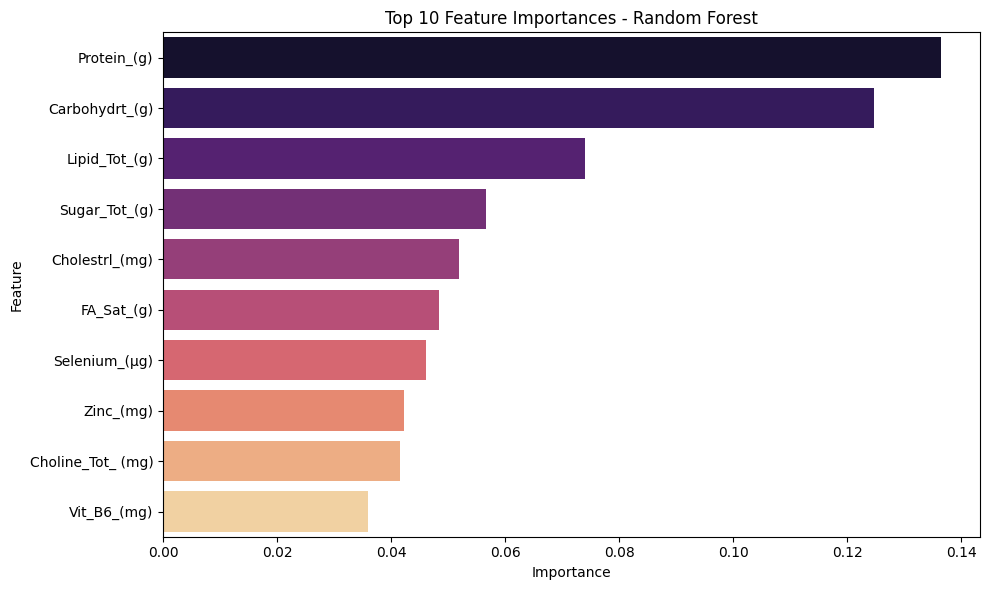

In [ ]:
# Imports
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load Data
data = pd.read_csv('/content/ABBREV.csv')

# Drop unnecessary columns
columns_to_drop = ['index', 'NDB_No', 'Shrt_Desc', 'GmWt_Desc1', 'GmWt_Desc2']
data.drop(columns=[col for col in columns_to_drop if col in data.columns], axis=1, inplace=True)

# Remove duplicates and NaNs
data = data.drop_duplicates()
data = data.dropna()

# Remove outliers using z-score
for col in data.select_dtypes(include=[np.number]).columns:
    z = np.abs(stats.zscore(data[col]))
    # Filter the DataFrame directly using the z-scores for the current column
    data = data[(z < 3)]

# Define deficiency based on thresholds
def classify_deficiency(row):
    if row["Protein_(g)"] < 0.3:
        return "Protein Deficiency"
    elif row["Carbohydrt_(g)"] < 0.3:
        return "Carb Deficiency"
    elif row["Lipid_Tot_(g)"] < 0.3:
        return "Fat Deficiency"
    else:
        return "Balanced"

data["deficiency"] = data.apply(classify_deficiency, axis=1)


print("\nClass distribution:\n", data["deficiency"].value_counts())

# Label encode the target
label_encoder = LabelEncoder()
data["deficiency_label"] = label_encoder.fit_transform(data["deficiency"])

# Features and Labels
X = data.drop(["deficiency", "deficiency_label"], axis=1)
y = data["deficiency_label"]

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42)
}

import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution Barplot
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x="deficiency", order=data["deficiency"].value_counts().index)
plt.title("Class Distribution of Nutrient Deficiencies")
plt.xlabel("Deficiency Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.2f}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")

# Store accuracy for plotting
accuracies = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((name, acc))

# Plot Accuracy Comparison
model_names = [name for name, _ in accuracies]
model_scores = [acc for _, acc in accuracies]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=model_scores, palette="viridis")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance from Random Forest
rf_model = models["Random Forest Classifier"]
importances = rf_model.feature_importances_
features = X.columns

# Plot
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10], palette="magma")
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


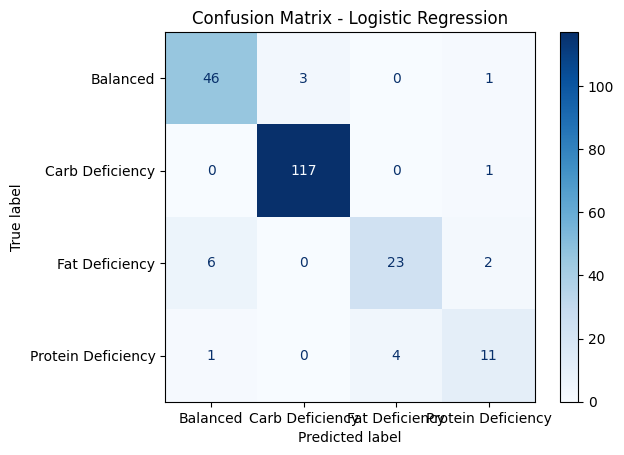

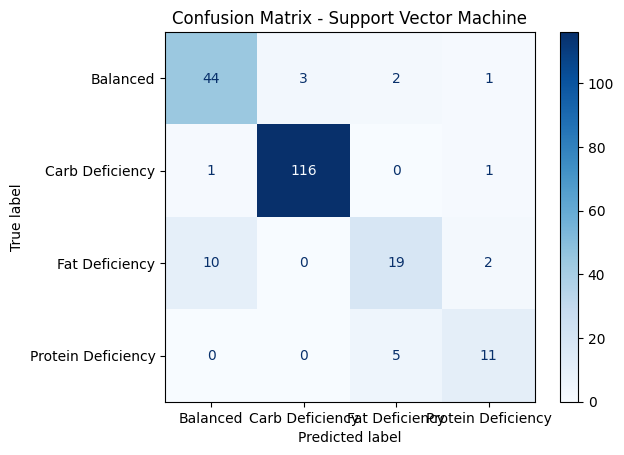

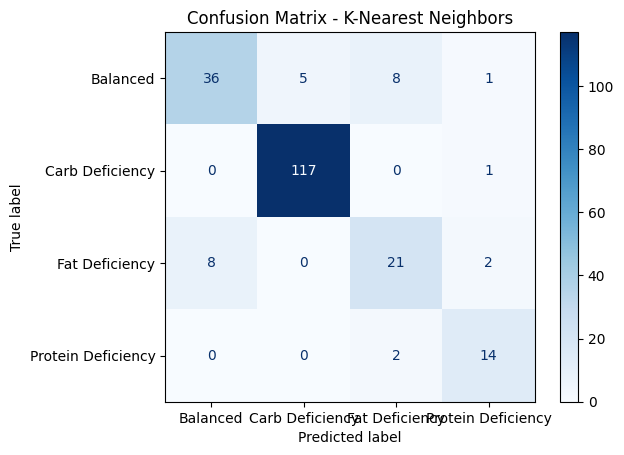

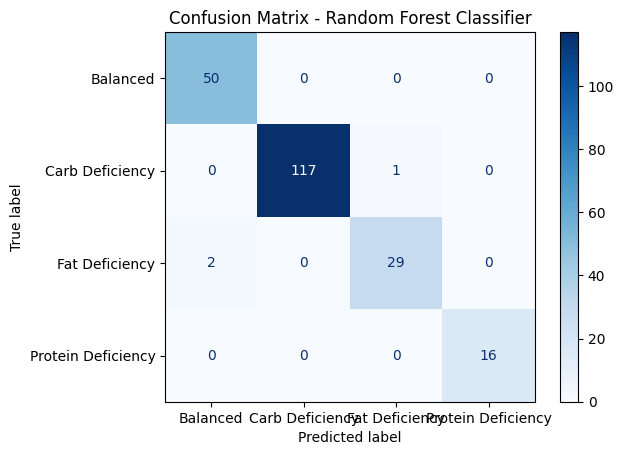

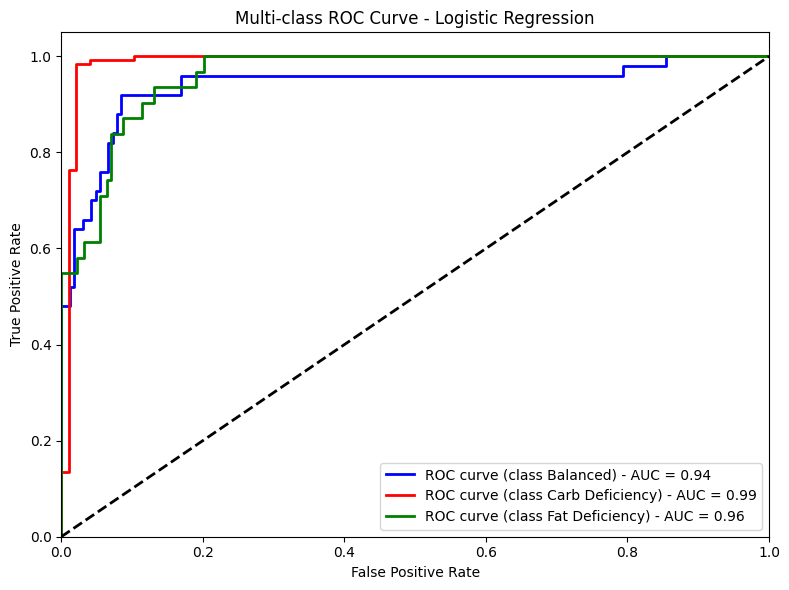

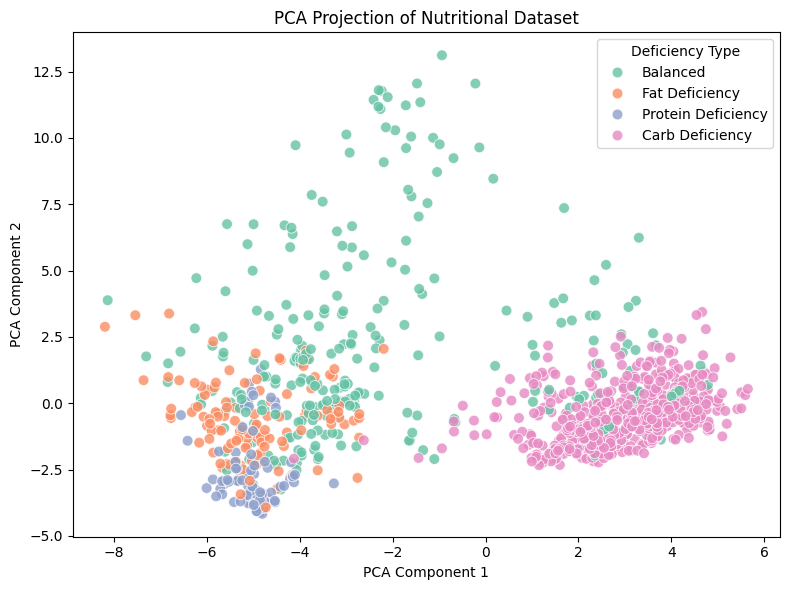

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Binarize the output labels for multi-class ROC
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=42)

# Use OneVsRestClassifier for multi-class ROC
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
y_score = classifier.fit(X_train_bin, y_train_bin).predict_proba(X_test_bin)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve (class {label_encoder.classes_[i]}) - AUC = {roc_auc[i]:0.2f}")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=label_encoder.inverse_transform(y),
                palette="Set2", s=60, alpha=0.8)
plt.title("PCA Projection of Nutritional Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Deficiency Type")
plt.tight_layout()
plt.show()
